In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from aisynphys.database import SynphysDatabase
from aisynphys.cell_class import CellClass

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## 1. Load and Analyze Allen Database

Load synaptic data from the Allen Institute database and extract amplitude measurements.


In [2]:
# Load database
db = SynphysDatabase.load_current('small')

# Define cell classes
cell_classes = {
    'ET': CellClass(cre_type='sim1', name='ET'),
    'IT': CellClass(cre_type='tlx3', name='IT'),
    'PV': CellClass(cre_type='pvalb', name='pvalb'),
    'SST': CellClass(cre_type='sst', name='sst')
}

# Query for synapses with amplitude data
pairs = None

for pre_name, pre_class in cell_classes.items():
    for post_name, post_class in cell_classes.items():
        # Query excitatory synapses
        pair_query_ex = db.pair_query(
            experiment_type='standard multipatch',
            species='mouse',
            pre_class=pre_class,
            post_class=post_class,
            synapse=True,
            synapse_type='ex',
            preload=['cell', 'synapse']
        )
        
        # Query inhibitory synapses
        pair_query_in = db.pair_query(
            experiment_type='standard multipatch',
            species='mouse',
            pre_class=pre_class,
            post_class=post_class,
            synapse=True,
            synapse_type='in',
            preload=['cell', 'synapse']
        )
        
        # Convert to dataframes
        df_ex = pair_query_ex.dataframe()
        df_in = pair_query_in.dataframe()
        
        # Add metadata columns
        df_ex['synapse_type'] = 'ex'
        df_in['synapse_type'] = 'in'
        df_ex['pre_cell'] = pre_name
        df_in['pre_cell'] = pre_name
        df_ex['post_cell'] = post_name
        df_in['post_cell'] = post_name
        
        # Concatenate
        if pairs is None:
            pairs = pd.concat([df_ex, df_in], ignore_index=True)
        else:
            pairs = pd.concat([pairs, df_ex, df_in], ignore_index=True)
        
        print(f"{len(df_ex)} ex + {len(df_in)} in synapses: {pre_name}→{post_name}")

print(f"\nTotal synapses loaded: {len(pairs)}")
print(f"\nSynapse types: {pairs['synapse_type'].value_counts().to_dict()}")
pairs.head()

102 ex + 1 in synapses: ET→ET
0 ex + 0 in synapses: ET→IT
5 ex + 0 in synapses: ET→PV
8 ex + 0 in synapses: ET→SST
0 ex + 0 in synapses: IT→ET
56 ex + 1 in synapses: IT→IT
29 ex + 0 in synapses: IT→PV
34 ex + 0 in synapses: IT→SST
0 ex + 18 in synapses: PV→ET
1 ex + 44 in synapses: PV→IT
19 ex + 354 in synapses: PV→PV
0 ex + 24 in synapses: PV→SST
0 ex + 20 in synapses: SST→ET
0 ex + 22 in synapses: SST→IT
3 ex + 72 in synapses: SST→PV
8 ex + 62 in synapses: SST→SST

Total synapses loaded: 883

Synapse types: {'in': 618, 'ex': 265}


,pair.id,pair.experiment_id,pair.pre_cell_id,pair.post_cell_id,pair.has_synapse,pair.has_polysynapse,pair.has_electrical,pair.crosstalk_artifact,pair.n_ex_test_spikes,pair.n_in_test_spikes,...,synapse_model.ml_paired_event_correlation_4_8_p,synapse_model.meta,synapse_type,pre_cell,post_cell,dynamics.stp_all_stimuli,synapse_model.parameter_space,synapse_model.marginal_distributions,synapse_model.confidence_intervals,synapse_model.ml_stp_all_stimuli
0,64242,1905,11266,11261,True,False,False,NaN,582,60,...,NaN,None,ex,ET,ET,NaN,NaN,NaN,NaN,NaN
1,37175,978,6148,6149,True,False,False,NaN,490,0,...,NaN,None,ex,ET,ET,NaN,NaN,NaN,NaN,NaN
2,37180,978,6148,6154,True,False,False,NaN,490,0,...,NaN,None,ex,ET,ET,NaN,NaN,NaN,NaN,NaN
3,37211,978,6154,6148,True,False,False,NaN,538,12,...,NaN,None,ex,ET,ET,NaN,NaN,NaN,NaN,NaN
4,37214,978,6154,6151,True,False,False,NaN,550,0,...,0.635346,{'pair_ext_id': '1497469151.704 8 5'},ex,ET,ET,NaN,NaN,NaN,NaN,NaN


## 2. Unit Conversion and Conductance Calculation

Convert raw database values (Volts, Amperes) to conventional units and calculate synaptic conductance.

**Assumptions:**
- **Excitatory synapses**: V_rev = 0 mV, V_hold = -70 mV → ΔV = 70 mV
- **Inhibitory synapses**: V_rev = -70 mV, V_hold = -55 mV → ΔV = -15 mV (measured at -55 mV for better visibility)

**Formula:** G_syn = I_psc / ΔV (where I_psc is in Amperes and ΔV in Volts)


In [3]:
# Convert units and calculate conductance
# Driving forces (in Volts) - use absolute values for conductance calculation
driving_force = {
    'ex': 0.07,    # 70 mV for excitatory (V_rev=0, V_hold=-70)
    'in': 0.015    # 15 mV for inhibitory (V_rev=-70, V_hold=-55) - using absolute value
}

# Convert PSP and PSC to conventional units
pairs['psp_amplitude_mV'] = pairs['synapse.psp_amplitude'] * 1000  # V to mV
pairs['psc_amplitude_pA'] = pairs['synapse.psc_amplitude'] * 1e12  # A to pA

# Calculate conductance in nanoSiemens (always positive)
mask = pd.notnull(pairs['synapse.psc_amplitude'])
pairs.loc[mask, 'gsyn_nS'] = np.abs(pairs.loc[mask, 'synapse.psc_amplitude'] / pairs.loc[mask, 'synapse_type'].map(driving_force)) * 1e9
pairs.loc[~mask, 'gsyn_nS'] = np.nan

# Remove rows with NaN conductance
synapses_valid = pairs.dropna(subset=['gsyn_nS'])

print(f"Valid synapses with conductance data: {len(synapses_valid)}")
print(f"\nExcitatory synapses: {len(synapses_valid[synapses_valid['synapse_type'] == 'ex'])}")
print(f"Inhibitory synapses: {len(synapses_valid[synapses_valid['synapse_type'] == 'in'])}")

# Summary statistics
print("\n=== Excitatory Synapses ===")
ex_data = synapses_valid[synapses_valid['synapse_type'] == 'ex']
print(f"PSP amplitude: {ex_data['psp_amplitude_mV'].mean():.2f} ± {ex_data['psp_amplitude_mV'].std():.2f} mV")
print(f"PSC amplitude: {ex_data['psc_amplitude_pA'].mean():.2f} ± {ex_data['psc_amplitude_pA'].std():.2f} pA")
print(f"Conductance: {ex_data['gsyn_nS'].mean():.2f} ± {ex_data['gsyn_nS'].std():.2f} nS")

print("\n=== Inhibitory Synapses ===")
in_data = synapses_valid[synapses_valid['synapse_type'] == 'in']
print(f"PSP amplitude: {in_data['psp_amplitude_mV'].mean():.2f} ± {in_data['psp_amplitude_mV'].std():.2f} mV")
print(f"PSC amplitude: {in_data['psc_amplitude_pA'].mean():.2f} ± {in_data['psc_amplitude_pA'].std():.2f} pA")
print(f"Conductance: {in_data['gsyn_nS'].mean():.2f} ± {in_data['gsyn_nS'].std():.2f} nS")

Valid synapses with conductance data: 503

Excitatory synapses: 180
Inhibitory synapses: 323

=== Excitatory Synapses ===
PSP amplitude: 0.36 ± 0.34 mV
PSC amplitude: -6.41 ± 8.15 pA
Conductance: 0.09 ± 0.12 nS

=== Inhibitory Synapses ===
PSP amplitude: -0.48 ± 0.48 mV
PSC amplitude: 11.00 ± 12.60 pA
Conductance: 0.73 ± 0.84 nS


## 3. Visualize Allen Data Distributions


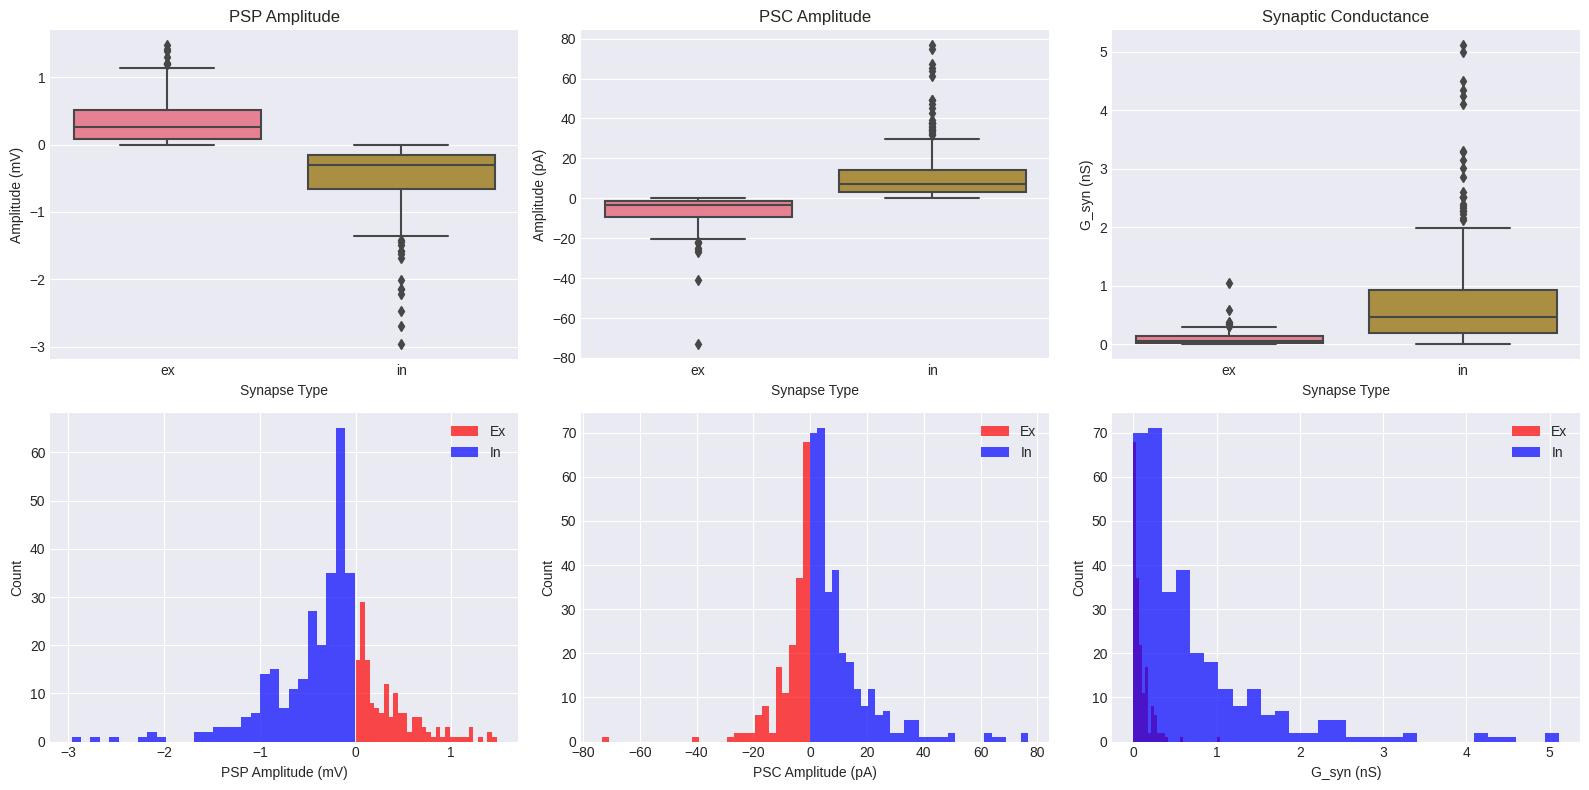

In [4]:
# Visualize distributions by synapse type
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

# PSP amplitude
sns.boxplot(data=synapses_valid, x='synapse_type', y='psp_amplitude_mV', ax=axes[0, 0])
axes[0, 0].set_title('PSP Amplitude')
axes[0, 0].set_ylabel('Amplitude (mV)')
axes[0, 0].set_xlabel('Synapse Type')

# PSC amplitude
sns.boxplot(data=synapses_valid, x='synapse_type', y='psc_amplitude_pA', ax=axes[0, 1])
axes[0, 1].set_title('PSC Amplitude')
axes[0, 1].set_ylabel('Amplitude (pA)')
axes[0, 1].set_xlabel('Synapse Type')

# Conductance
sns.boxplot(data=synapses_valid, x='synapse_type', y='gsyn_nS', ax=axes[0, 2])
axes[0, 2].set_title('Synaptic Conductance')
axes[0, 2].set_ylabel('G_syn (nS)')
axes[0, 2].set_xlabel('Synapse Type')

# Distribution histograms
axes[1, 0].hist(ex_data['psp_amplitude_mV'].dropna(), bins=30, alpha=0.7, label='Ex', color='red')
axes[1, 0].hist(in_data['psp_amplitude_mV'].dropna(), bins=30, alpha=0.7, label='In', color='blue')
axes[1, 0].set_xlabel('PSP Amplitude (mV)')
axes[1, 0].set_ylabel('Count')
axes[1, 0].legend()

axes[1, 1].hist(ex_data['psc_amplitude_pA'].dropna(), bins=30, alpha=0.7, label='Ex', color='red')
axes[1, 1].hist(in_data['psc_amplitude_pA'].dropna(), bins=30, alpha=0.7, label='In', color='blue')
axes[1, 1].set_xlabel('PSC Amplitude (pA)')
axes[1, 1].set_ylabel('Count')
axes[1, 1].legend()

axes[1, 2].hist(ex_data['gsyn_nS'].dropna(), bins=30, alpha=0.7, label='Ex', color='red')
axes[1, 2].hist(in_data['gsyn_nS'].dropna(), bins=30, alpha=0.7, label='In', color='blue')
axes[1, 2].set_xlabel('G_syn (nS)')
axes[1, 2].set_ylabel('Count')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

## 4. Synaptic Strength by Cell Pair

Analyze synaptic conductance (strength) for each pre→post cell type combination.

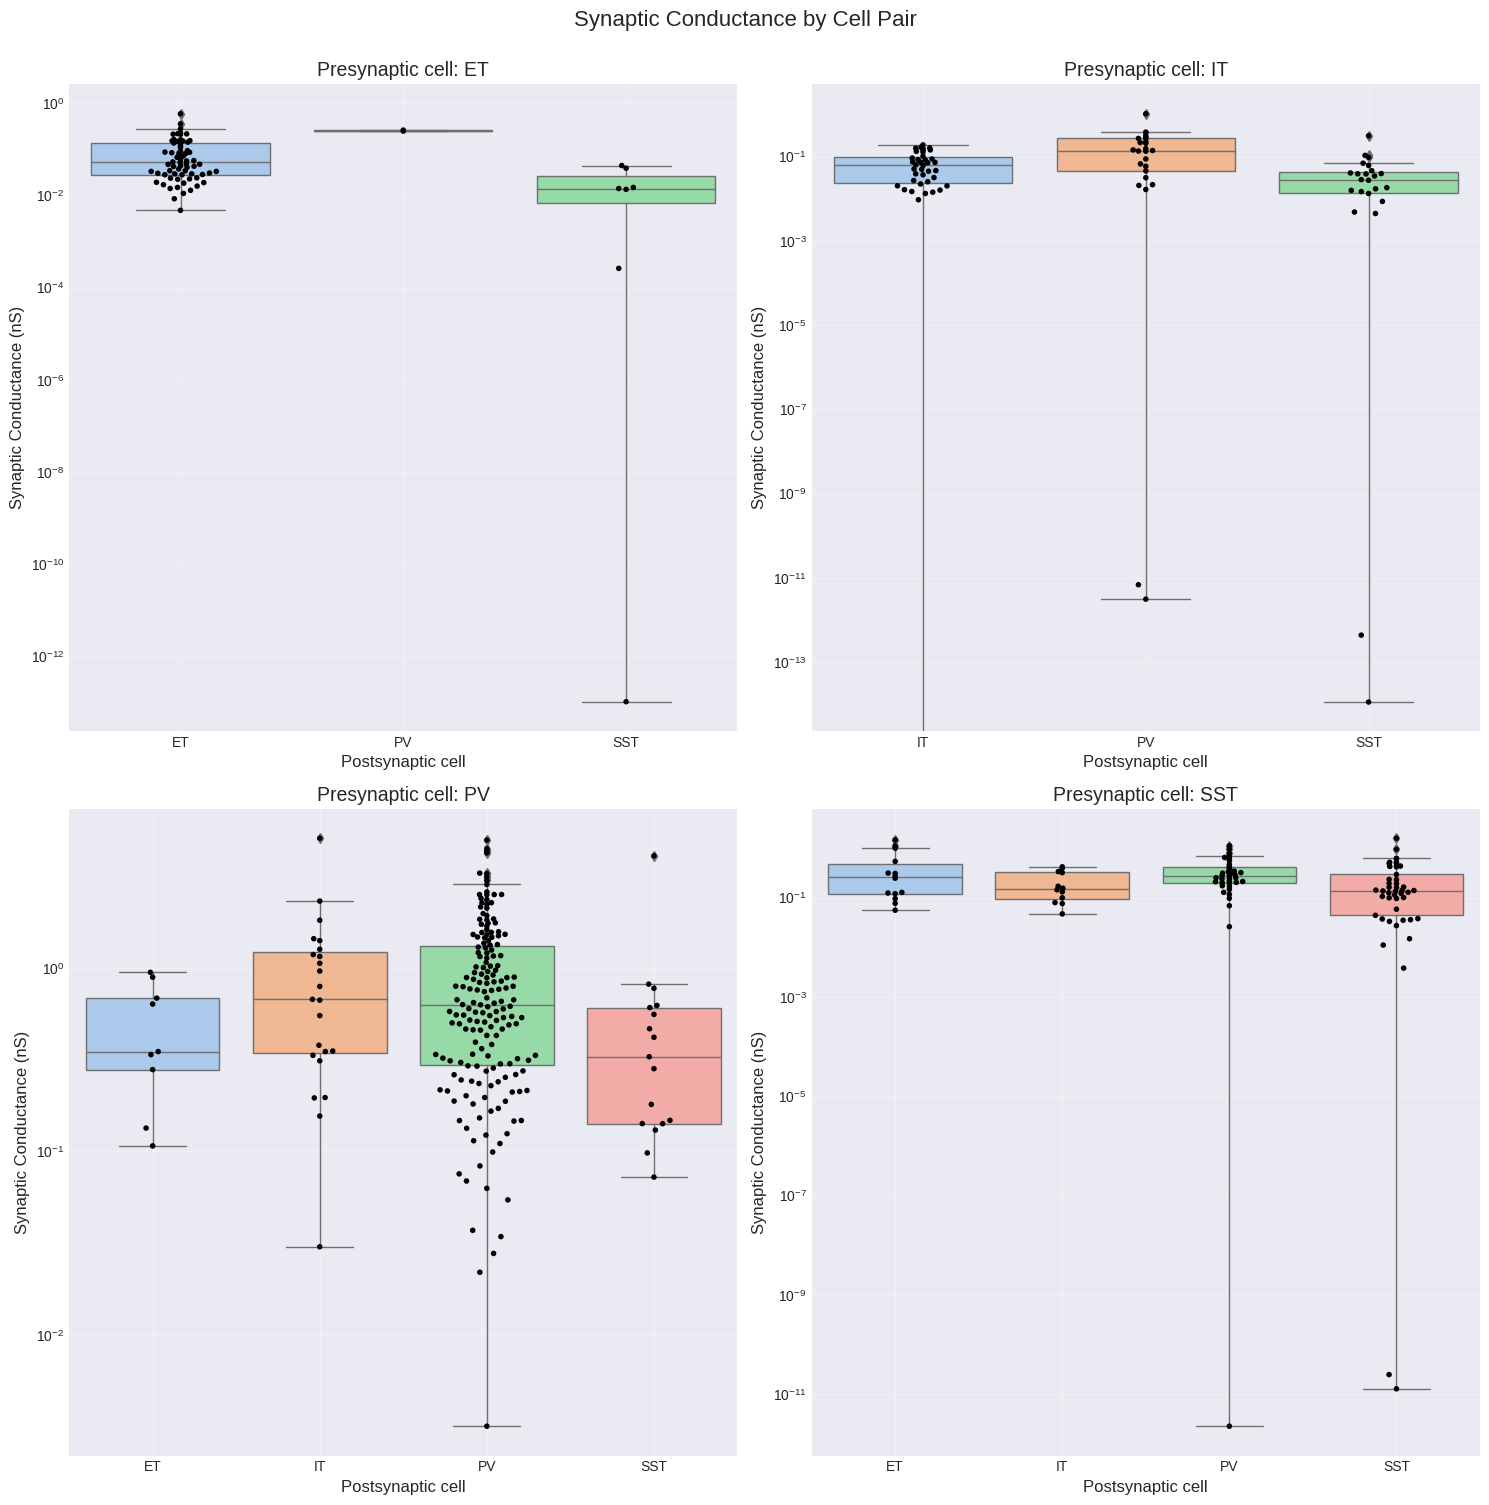

In [5]:
# Visualize conductance by cell pairs (similar to chemical_synapses.ipynb)
pre_cells = synapses_valid['pre_cell'].unique()
post_cells = synapses_valid['post_cell'].unique()

# Create comprehensive figure showing conductance for all cell pair combinations
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.ravel()

for j, pre_cell in enumerate(pre_cells):
    pre_data = synapses_valid[synapses_valid['pre_cell'] == pre_cell]
    
    # Box plot with individual data points
    sns.boxplot(x="post_cell", y='gsyn_nS', data=pre_data,
                ax=axes[j], palette='pastel', width=0.8, linewidth=1)
    sns.swarmplot(x="post_cell", y='gsyn_nS', data=pre_data, 
                  ax=axes[j], size=4, color=(0, 0, 0, 0.5))
    
    # Formatting
    axes[j].set_title(f"Presynaptic cell: {pre_cell}", size=14)
    axes[j].set_xlabel("Postsynaptic cell", size=12)
    axes[j].set_ylabel("Synaptic Conductance (nS)", size=12)
    axes[j].set_yscale('log')
    axes[j].grid(True, alpha=0.3)

plt.suptitle("Synaptic Conductance by Cell Pair", size=16, y=1.00)
plt.tight_layout()
plt.show()

In [6]:
# Summary statistics for each cell pair
rows = []
for pre_cell in pre_cells:
    for post_cell in post_cells:
        data = synapses_valid[(synapses_valid['pre_cell'] == pre_cell) & 
                              (synapses_valid['post_cell'] == post_cell)]
        
        if len(data) > 0:
            # Calculate statistics for conductance
            gsyn_log = np.log(data['gsyn_nS'])
            gsyn_log_mean = np.mean(gsyn_log)
            gsyn_log_std = np.std(gsyn_log)
            gsyn_log_quartiles = gsyn_log_mean + 0.6745 * gsyn_log_std * np.array([-1, 1])
            gsyn_median = np.exp(gsyn_log_mean)
            gsyn_quartiles = np.round(np.exp(gsyn_log_quartiles), 3)
            
            # Also get PSP and PSC stats
            psp_median = data['psp_amplitude_mV'].median()
            psp_quartiles = np.round([data['psp_amplitude_mV'].quantile(0.25), 
                                     data['psp_amplitude_mV'].quantile(0.75)], 3)
            
            psc_median = data['psc_amplitude_pA'].median()
            psc_quartiles = np.round([data['psc_amplitude_pA'].quantile(0.25), 
                                     data['psc_amplitude_pA'].quantile(0.75)], 3)
            
            # Determine dominant synapse type
            synapse_type_counts = data['synapse_type'].value_counts()
            dominant_type = synapse_type_counts.idxmax() if len(synapse_type_counts) > 0 else 'N/A'
            
            row = {
                'pre_cell': pre_cell,
                'post_cell': post_cell,
                'n_synapses': len(data),
                'synapse_type': dominant_type,
                'gsyn_median (nS)': np.round(gsyn_median, 3),
                'gsyn_quartiles (nS)': gsyn_quartiles,
                'psp_median (mV)': np.round(psp_median, 3),
                'psp_quartiles (mV)': psp_quartiles,
                'psc_median (pA)': np.round(psc_median, 3),
                'psc_quartiles (pA)': psc_quartiles,
            }
            rows.append(row)

strength_df = pd.DataFrame(rows)
strength_df = strength_df.sort_values(['pre_cell', 'post_cell'])
strength_df

,pre_cell,post_cell,n_synapses,synapse_type,gsyn_median (nS),gsyn_quartiles (nS),psp_median (mV),psp_quartiles (mV),psc_median (pA),psc_quartiles (pA)
0,ET,ET,69,ex,0.055,"[0.029, 0.106]",0.285,"[0.124, 0.515]",-3.635,"[-9.354, -1.954]"
1,ET,PV,2,ex,0.252,"[0.248, 0.257]",1.017,"[0.817, 1.217]",-17.668,"[-17.894, -17.442]"
2,ET,SST,7,ex,0.000,"[0.0, 0.12]",0.053,"[0.029, 0.067]",-0.981,"[-1.869, -0.48]"
5,IT,IT,39,ex,0.000,"[nan, nan]",0.227,"[0.074, 0.493]",-4.331,"[-6.849, -1.676]"
3,IT,PV,25,ex,0.018,"[0.0, 1.579]",0.443,"[0.344, 0.946]",-9.782,"[-18.916, -3.221]"
4,IT,SST,23,ex,0.003,"[0.0, 0.494]",0.072,"[0.03, 0.237]",-1.996,"[-3.062, -0.987]"
6,PV,ET,9,in,0.383,"[0.232, 0.632]",-0.378,"[-0.732, -0.3]",5.261,"[4.193, 10.292]"
9,PV,IT,23,in,0.615,"[0.3, 1.261]",-0.557,"[-0.81, -0.345]",10.133,"[5.138, 18.399]"
7,PV,PV,178,in,0.580,"[0.271, 1.24]",-0.463,"[-0.878, -0.19]",9.473,"[4.424, 19.902]"
8,PV,SST,17,in,0.325,"[0.168, 0.628]",-0.379,"[-0.505, -0.151]",4.929,"[2.128, 9.135]"


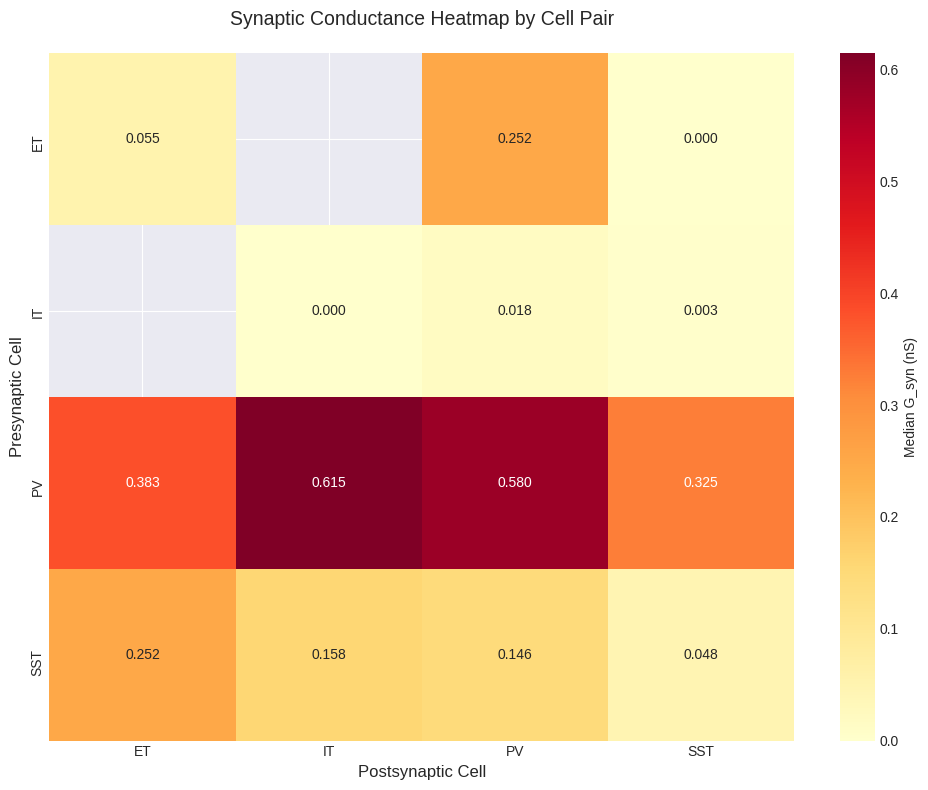

In [7]:
# Create heatmap of median synaptic conductance
pivot_table = strength_df.pivot(index='pre_cell', columns='post_cell', values='gsyn_median (nS)')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='YlOrRd', 
            cbar_kws={'label': 'Median G_syn (nS)'})
plt.title('Synaptic Conductance Heatmap by Cell Pair', size=14, pad=20)
plt.xlabel('Postsynaptic Cell', size=12)
plt.ylabel('Presynaptic Cell', size=12)
plt.tight_layout()
plt.show()

SST→IT Synapses: 12 connections found

Synaptic Conductance (G_syn):
  Median: 0.149 nS
  Mean: 0.196 ± 0.131 nS
  Range: 0.047 - 0.416 nS

PSP Amplitude:
  Median: -0.204 mV
  Mean: -0.236 ± 0.170 mV

PSC Amplitude:
  Median: 2.237 pA
  Mean: 2.946 ± 1.966 pA


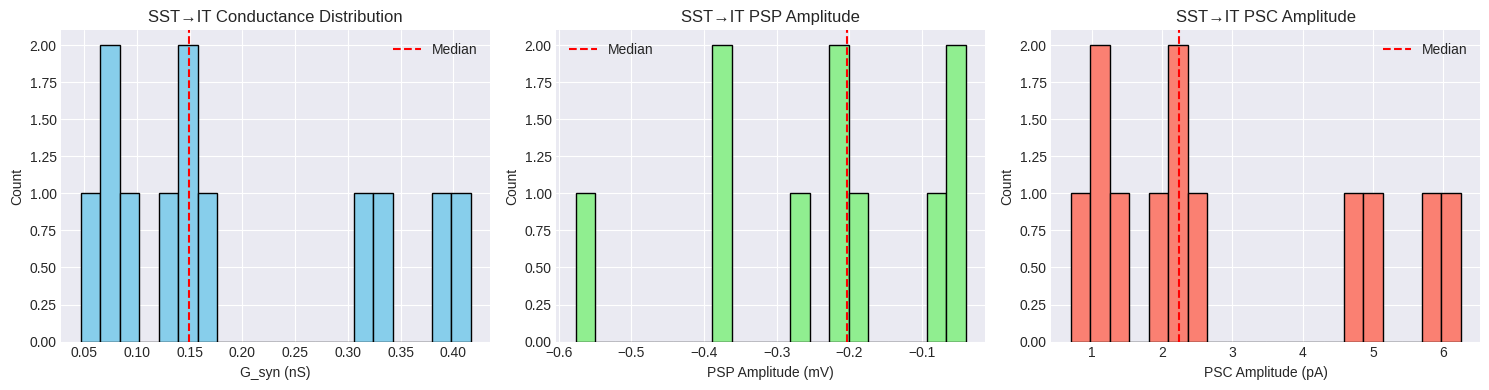

In [9]:
# Change cell pair here to change graph
pre_cell_to_plot = 'SST'
post_cell_to_plot = 'IT'
pv_to_et = synapses_valid[(synapses_valid['pre_cell'] == pre_cell_to_plot) & 
                          (synapses_valid['post_cell'] == post_cell_to_plot)]

print(f"{pre_cell_to_plot}→{post_cell_to_plot} Synapses: {len(pv_to_et)} connections found")
print(f"\nSynaptic Conductance (G_syn):")
print(f"  Median: {pv_to_et['gsyn_nS'].median():.3f} nS")
print(f"  Mean: {pv_to_et['gsyn_nS'].mean():.3f} ± {pv_to_et['gsyn_nS'].std():.3f} nS")
print(f"  Range: {pv_to_et['gsyn_nS'].min():.3f} - {pv_to_et['gsyn_nS'].max():.3f} nS")
print(f"\nPSP Amplitude:")
print(f"  Median: {pv_to_et['psp_amplitude_mV'].median():.3f} mV")
print(f"  Mean: {pv_to_et['psp_amplitude_mV'].mean():.3f} ± {pv_to_et['psp_amplitude_mV'].std():.3f} mV")
print(f"\nPSC Amplitude:")
print(f"  Median: {pv_to_et['psc_amplitude_pA'].median():.3f} pA")
print(f"  Mean: {pv_to_et['psc_amplitude_pA'].mean():.3f} ± {pv_to_et['psc_amplitude_pA'].std():.3f} pA")


fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(pv_to_et['gsyn_nS'], bins=20, color='skyblue', edgecolor='black')
axes[0].axvline(pv_to_et['gsyn_nS'].median(), color='red', linestyle='--', label='Median')
axes[0].set_xlabel('G_syn (nS)')
axes[0].set_ylabel('Count')
axes[0].set_title(f'{pre_cell_to_plot}→{post_cell_to_plot} Conductance Distribution')
axes[0].legend()

axes[1].hist(pv_to_et['psp_amplitude_mV'], bins=20, color='lightgreen', edgecolor='black')
axes[1].axvline(pv_to_et['psp_amplitude_mV'].median(), color='red', linestyle='--', label='Median')
axes[1].set_xlabel('PSP Amplitude (mV)')
axes[1].set_ylabel('Count')
axes[1].set_title(f'{pre_cell_to_plot}→{post_cell_to_plot} PSP Amplitude')
axes[1].legend()

axes[2].hist(pv_to_et['psc_amplitude_pA'], bins=20, color='salmon', edgecolor='black')
axes[2].axvline(pv_to_et['psc_amplitude_pA'].median(), color='red', linestyle='--', label='Median')
axes[2].set_xlabel('PSC Amplitude (pA)')
axes[2].set_ylabel('Count')
axes[2].set_title(f'{pre_cell_to_plot}→{post_cell_to_plot} PSC Amplitude')
axes[2].legend()

plt.tight_layout()
plt.show()